In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
#import tensorflow_datasets as tf_datasets
import sklearn
import seaborn as sns
import os
import datetime
import keras

%load_ext tensorboard

/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of 

In [2]:
# get the data set
#mnist_builder = tf_datasets.image.mnist.MNIST()
#mnist_builder.download_and_prepare()
#mnist = mnist_builder.as_dataset()
mnist = keras.datasets.mnist.load_data()
#mnist

In [3]:
mnist_X_train = np.array(mnist[0][0]) / 255
mnist_y_train = np.array(mnist[0][1])
mnist_X_test = np.array(mnist[1][0]) / 255
mnist_y_test = np.array(mnist[1][1])

print(mnist_X_train.shape)
print(mnist_y_train.shape)
print(mnist_X_test.shape)
print(mnist_y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


1.0


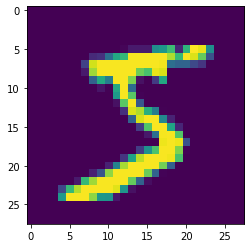

In [4]:
plt.imshow(mnist_X_train[0, :].reshape(28, 28))
print(max(mnist_X_train[0, :, :].reshape(-1)))

In [5]:
encoding_size = 30

In [6]:
logdir = './tb_logs'
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [7]:
# Simple dense layer model

enc_input = l = keras.layers.Input(shape=(28, 28, 1))
l = keras.layers.Conv2D(16, (4, 4), activation='relu', padding='same')(l)
l = keras.layers.MaxPooling2D((3, 3), padding='same')(l)
l = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(l)
l = keras.layers.MaxPooling2D((2, 2), padding='same')(l)
l = keras.layers.Flatten()(l)
l = keras.layers.Dense(encoding_size, activation='tanh')(l)
encoder = keras.models.Model(inputs=enc_input, outputs=l)

dec_input = l = keras.layers.Input(shape=(encoding_size,))
l = keras.layers.Dense(28*28, activation='relu')(l)
l = keras.layers.Reshape(target_shape=(28, 28, 1))(l)
l = keras.layers.Conv2D(16, (4, 4), activation='relu', padding='same')(l)
l = keras.layers.MaxPooling2D((3, 3), padding='same')(l)
l = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(l)
l = keras.layers.MaxPooling2D((2, 2), padding='same')(l)
l = keras.layers.Flatten()(l)
l = keras.layers.Dense(28*28, activation='sigmoid')(l)
l = keras.layers.Reshape(target_shape=(28, 28))(l)
decoder = keras.models.Model(inputs=dec_input, outputs=l)

autocoder = keras.models.Model(inputs=enc_input, outputs=decoder(encoder(enc_input)))

autocoder.compile(optimizer='adadelta', loss='binary_crossentropy')







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
autocoder.fit(
    mnist_X_train.reshape(-1, 28, 28, 1),
    mnist_X_train,
    epochs=50, 
    batch_size=512,
    shuffle=True, 
    validation_data=(mnist_X_test.reshape(-1, 28, 28, 1), mnist_X_test)
)


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 13s 209us/step - loss: 0.4147 - val_loss: 0.2637
Epoch 2/50
60000/60000 [==============================] - 12s 192us/step - loss: 0.2630 - val_loss: 0.2629
Epoch 3/50
60000/60000 [==============================] - 12s 199us/step - loss: 0.2613 - val_loss: 0.2602
Epoch 4/50
60000/60000 [==============================] - 13s 213us/step - loss: 0.2568 - val_loss: 0.2527
Epoch 5/50
60000/60000 [==============================] - 13s 215us/step - loss: 0.2496 - val_loss: 0.2456
Epoch 6/50
60000/60000 [==============================] - 13s 220us/step - loss: 0.2444 - val_loss: 0.2410
Epoch 7/50
60000/60000 [==============================] - 13s 220us/step - loss: 0.2375 - val_loss: 0.2359
Epoch 8/50
60000/60000 [==============================] - 13s 217us/step - loss: 0.2329 - val_loss: 0.2324
Epoch 9/50
60000/60000 [==============================] - 12s 206us/step - loss: 0.2298 - val

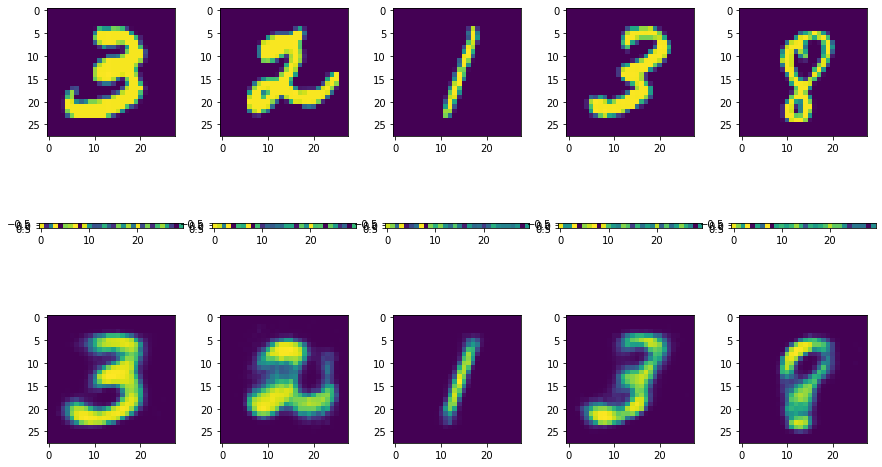

In [15]:
plt.figure(figsize=(15, 8))

n = 5

for i, j in zip(range(n), np.random.randint(0, 10000, size=n)):
    original = mnist_X_test[j, :]
    encoded = encoder.predict(original.reshape(1, 28, 28, 1))[0]
    decoded = decoder.predict(encoded.reshape(1, -1))[0]
    
    plt.subplot(3, n, i+1)
    plt.imshow(original)
    
    plt.subplot(3, n, i+n+1)
    plt.imshow(encoded.reshape(1, -1))

    plt.subplot(3, n, i+n+n+1)
    plt.imshow(decoded)

In [10]:
import sklearn.decomposition

# Compute PCA
encoded_train_images = encoder.predict(mnist_X_train.reshape(-1, 28, 28, 1))
encoded_test_images = encoder.predict(mnist_X_test.reshape(-1, 28, 28, 1))

pca = sklearn.decomposition.PCA(n_components=encoding_size)
pca.fit(encoded_train_images)

pca_train_images = pca.transform(encoded_train_images)

minmax = sklearn.preprocessing.MinMaxScaler()
minmax.fit(pca_train_images)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [11]:
import ipywidgets

def draw_pca(x1, x2, x3, x4, x5, x6, x7, x8, x9, x10):
    vec = np.array([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]).reshape(1, -1)
    plt.imshow(decoder.predict(pca.inverse_transform(vec)).reshape(28, 28))

ipywidgets.interact(draw_pca, 
         x1=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x2=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x3=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x4=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x5=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x6=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x7=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x8=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x9=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x10=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False));

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x1', max=1.0, min=-1.0, ste…

In [12]:
v = encoded_train_images[2]
v

array([ 0.95041746, -0.5332656 ,  0.67426383,  0.8609012 , -0.8567779 ,
       -0.10896027,  0.15888795,  0.9851745 , -0.9659699 , -0.3709423 ,
        0.06782956, -0.34020323,  0.01921606, -0.46942088,  0.29866397,
        0.24760482, -0.12275291,  0.5420984 , -0.67346805, -0.65949893,
        0.7931838 , -0.34263492, -0.13482721,  0.1814573 ,  0.7109149 ,
       -0.8306823 ,  0.8020385 ,  0.40611514, -0.89931315,  0.3020545 ],
      dtype=float32)

In [13]:
v2 = pca.transform(v.reshape(1, -1))
v2

array([[ 3.38894486e-01,  1.37974715e+00, -7.36619234e-02,
        -8.35356116e-01,  7.16469884e-01, -2.26083286e-02,
         1.07317567e+00,  1.44650325e-01, -2.78333098e-01,
        -1.87531888e-01, -4.78217423e-01, -2.56015837e-01,
        -2.09116682e-01,  7.89631665e-01, -1.50887609e-01,
         1.44062519e-01, -1.31708920e-01, -1.05177112e-01,
         1.30380690e-01,  2.77597845e-01,  1.49128780e-01,
         1.15251355e-01,  1.23148449e-01,  2.33863041e-01,
         7.92402774e-04, -1.99091453e-02,  4.82408330e-03,
         4.43885699e-02,  6.95184097e-02, -1.49398884e-02]], dtype=float32)

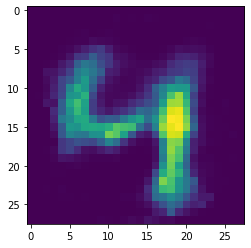

In [14]:
plt.imshow(decoder.predict(pca.inverse_transform(v2))[0])